# Capstone 2: Modeling
<b>PROJECT GOAL</b><br>
The overall goal of this project is to understand and predict a time series on delinquency rate (response variable) for lease contracts originated by U.S. banks.  Time series for several predictor (exogenous) variables will be included in an attempt to identify economic variables that may help explain and thus predict future lease delinquency rates.<br>

<b>DATA</b><br>
<i>all series have been converted to quarterly data as of each calendar quarter end</i><br>

<i>response variable</i><br>
'delinq' = Lease Delinquency Rate, all banks; www.federalreserve.gov/datadownload/)<br><br>
<i>predictor (exogenous) variables (features)</i><br>
'ls_rcvbl' = Lease Receivable Balance, all banks; www.federalreserve.gov/datadownload/)<br>
'pmi_man' = ISM Purchasing Managers Index (PMI); www.quandl.com/data/ISM/MAN_PMI-PMI-Composite-Index<br>
'cons_sent' = Univ of Michigan Index of Consumer Sentiment; www.sca.isr.umich.edu/tables.html <br>
'close_price' = S&P 500 Price Index; finance.yahoo.com<br>
'stdtght_ci_smll_netpct' = Loan Standard Tightening, net percentage, commercial and industrial loans from small banks; www.federalreserve.gov/datadownload/)<br>
'tot_bus_inv' = Total Business Inventories; www.census.gov/economic-indicators/ <br>
'ret_sales' = Retail Sales; www.census.gov/economic-indicators/ <br>

<b>MODELING NOTEBOOK</b><br>
The purpose of this notebook is to:
<ol type="1">
    <li>Build on the findings of the last two notebooks by fitting a simple linear regression model for lease delinquency rate that incorporates the best features previously identified.  In this way, we can compare the time series model to a basic regression model to help further understand the impact of the different features for predicting lease delinquency rate and assess the performance of the time series models to the classic linear regression model as a kind of standard benchmark.</li>
    <li>Using the linear regression model, identify the relative importance of the different features.</li>
    <li>For the four models under consideration for predicting lease delinquency rate - the three best time series models and the linear regression model - compare the Mean Absolute Percent Error (MAPE) among the models.</li>
    <li>Analyze the partial autocorrelation of the residuals for the four models.</li>
    <li>Interpret the results from a model-fitting perspective and from a business use case perspective.</li>
    <li>Suggest next steps that could be considered to better understand and predict lease delinquency rate.</li>
</ol> 

The methodology follows the time series and regression methods in Hyndman and Athanasopoulos 2021 (hereafter, [HA 2021]).

<i>References</i><br>
Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3.

## 1 Import Python Modules, Load Data, Define Features
### <b>1.1 Import Python Modules </b>

In [1]:
import pickle
import warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pmdarima.model_selection import train_test_split as pm_tts
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
import seaborn as sns


### <b>1.2 Load Data </b>
* time series data
* results from time series training and testing

In [2]:
#time series data
filnm01 = '../data/delinq_transformed_subsets.pkl'

with open(filnm01, 'rb') as f01:
    data_objects01 = pickle.load(f01)
    
subset_meta = data_objects01[0]
row_subsets = data_objects01[1]
df_subsets = data_objects01[2]
df_ln_subsets = data_objects01[3]
df_lndif01_subsets = data_objects01[4]

df_full = df_subsets[2]
df_ln_full = df_ln_subsets[2]
df_lndif01_full = df_lndif01_subsets[2]

#model training and testing results
filnm02 = '../data/delinq_modelfit_results.pkl'

with open(filnm02, 'rb') as f02:
    data_objects02 = pickle.load(f02)
    
df_base_arima_cv_res = data_objects02[0] 
df_exog_arima_cv_res = data_objects02[1] 
df_full_arima_cv_res = data_objects02[2] 
df_base_pred_best = data_objects02[3] 
df_exog_pred_best = data_objects02[4] 
df_full_pred_best = data_objects02[5] 

## 2 Linear Regression Model: Fit to Time Series
<ol type="1">
   <li>The Exploratory Data Analysis and the model fitting in the Preprocessing and Training notebook identified several features that are correlated with lease delinquency rate.</li>
   <li>For the Linear Regression Model, I included eight features as linear predictors: delinquency at lags 1,2; pmi_man at lags 1,2,3; and ls_rcvbl at lags 7,8,9.  These features were correlated with lease deliquency rate in the Exploratory Data Analysis and/or present in the best time series models fit in the Preprocessing and Training notebook, or near lags for variables indicated as correlated in these prior analyses (for example, pmi_man lag 2 is included because it is near pmi_man lag 1 which is a best-fit feature).</li>
</ol>

### <b>2.1 Define Features </b>
Build the data set for the eight features described above. As in the time series analyses, model fitting is done natural-log tranformed first differences of all series and test data are the last 4 data points in the lease deliquency rate time series.

In [3]:
#y: delinq lag 0
#x12: delinq lag 1, lag 2
#x345: pmi_man 1,2,3
#x678: ls_rcvbl 7,8,9

colset01 = ['delinq','pmi_man','ls_rcvbl']
lagset01 = [[0,1,2],[1,2,3],[7,8,9]]
df_varn01 = pd.DataFrame()
df_lndif01_reg = pd.DataFrame()

ct01 = 0
ct02 = 0
for col01 in colset01:
    ct01 = ct01 +1 
    for lag01 in lagset01[ct01-1]:
        ct02 = ct02 +1
            
        df_varn01 = df_lndif01_full[[col01]].shift(periods=lag01,axis=0)
        df_varn01.columns = [col01 + '_' + str(lag01)]
        if ct02 > 1:
            df_lndif01_reg = pd.concat([df_lndif01_reg, df_varn01], axis=1, join='inner')
        else:
            df_lndif01_reg = df_varn01

df_lndif01_reg.dropna(inplace=True)           

### <b>2.2 Define Train, Test Data</b>

In [4]:
#define y, X
df_lndif01_y = df_lndif01_reg[['delinq_0']]
X_colnm01 = ['delinq_1', 'delinq_2', 'pmi_man_1', 'pmi_man_2', 'pmi_man_3', 'ls_rcvbl_7', 'ls_rcvbl_8', 'ls_rcvbl_9']
df_lndif01_X = df_lndif01_reg[X_colnm01]

#define train, test split
df_lndif01_y_train, df_lndif01_y_test = pm_tts(df_lndif01_y, test_size=4)
df_lndif01_X_train, df_lndif01_X_test = pm_tts(df_lndif01_X, test_size=4)

#record counts
print('y: train data record count:',df_lndif01_y_train['delinq_0'].count())
print('y: test data record count:',df_lndif01_y_test['delinq_0'].count())
print('X: train data record count:',df_lndif01_X_train['delinq_1'].count())
print('X: test data record count:',df_lndif01_X_test['delinq_1'].count())

y: train data record count: 103
y: test data record count: 4
X: train data record count: 103
X: test data record count: 4


Subsets for training, test data sets.

In [5]:
#shift lag 1 of ln data to back-transform
df_ln_full_lag1 = df_ln_full.shift(periods=1,axis=0)

#define subsets
#train ln dif01 (ex NaN from lag shift)
is_train_exlag_idx01 = (df_full.index >= df_lndif01_y_train.index.min()) & (df_full.index <= df_lndif01_y_train.index.max())
#test ln dif01
is_test_idx01 = (df_full.index >= df_lndif01_y_test.index.min()) & (df_full.index <= df_lndif01_y_test.index.max())
#train union test ln dif01
is_traintest_exlag_idx01 = is_train_exlag_idx01 | is_test_idx01

### <b>2.3 Fit Linear Regression Model: Calculate Fit Metrics</b>
Fit the linear regression model on the training data, calculate predictions on training and test data, back transform to original data, calculate residuals, and calculate absolute percent error (APE).

In [6]:
#fit linear regression model, predict, back transform
LR_model = LinearRegression()
LR_fit = LR_model.fit(df_lndif01_X_train, df_lndif01_y_train)
y_lndif01_train_pred = LR_fit.predict(df_lndif01_X_train)
y_lndif01_test_pred = LR_fit.predict(df_lndif01_X_test)

#back transform, to dataframe
y_ln_pred = np.concatenate((y_lndif01_train_pred,y_lndif01_test_pred)) + np.array(df_ln_full_lag1.loc[is_traintest_exlag_idx01,['delinq']])
y_pred = np.exp(y_ln_pred)
df_reg_pred = pd.DataFrame(y_pred)
df_reg_pred.columns = ['y_pred_reg']  
df_reg_pred.index = df_ln_full_lag1.loc[is_traintest_exlag_idx01,['delinq']].index

#residuals, calc abs percent error (APE)
df_reg_pred['y_resid_reg'] = df_full.loc[is_traintest_exlag_idx01,'delinq'] - df_reg_pred['y_pred_reg']
num_01 = np.abs(df_reg_pred['y_pred_reg'] - df_full.loc[is_traintest_exlag_idx01,'delinq'])
den_01 = np.abs(df_full.loc[is_traintest_exlag_idx01,'delinq'])
df_reg_pred['y_ape_reg'] = num_01/den_01

### <b>2.4 Linear Regression Model: Plot Actual, Predicted Values with Residuals</b>

Text(0.1, 15.5, 'reg std(resid) = 0.1125')

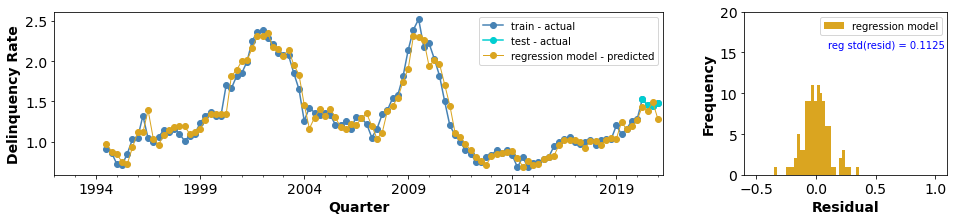

In [7]:
#Plot actual, predicted values for training, test data for regression model
fig01, axes01 = plt.subplots(nrows=1,ncols=2,figsize=(16,3),gridspec_kw={'width_ratios': [3, 1]})
  
#line plot
#train: actual
df_full.loc[is_traintest_exlag_idx01,'delinq'].plot(ax=axes01[0],style="-o",linewidth=1.5,color='steelblue')
#test: actual
df_full.loc[is_test_idx01,'delinq'].plot(ax=axes01[0],style="-o",linewidth=1.5,color='darkturquoise')
#train: predicted, forecast - regression
df_reg_pred['y_pred_reg'].plot(ax=axes01[0],style="-o",linewidth=1.0,color='goldenrod')

#format
axes01[0].set_xlabel('Quarter', fontsize = 14.0, fontweight='bold')
axes01[0].tick_params(axis='x', labelsize=14)
axes01[0].set_ylabel('Delinquency Rate', fontsize = 14.0, fontweight='bold') 
axes01[0].tick_params(axis='y', labelsize=14)
axes01[0].set_xlim('1992Q1', '2021Q2')
axes01[0].legend(labels=['train - actual','test - actual','regression model - predicted'],fontsize=10.0)

#histogram plot
df_reg_pred['y_resid_reg'].plot(ax=axes01[1],kind='hist',bins=30,color='goldenrod')
axes01[1].set_xlabel('Residual', fontsize=14.0, fontweight='bold')
axes01[1].tick_params(axis='x', labelsize=14)
axes01[1].set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
axes01[1].tick_params(axis='y', labelsize=14) 
axes01[1].legend(labels=['regression model'],fontsize=10.0)
axes01[1].set_xlim(-0.60,+1.1)
axes01[1].set_ylim(0,20)

#annotate
stdres_reg01 = np.std(df_reg_pred['y_resid_reg'])
x_stdres_reg01 = 0.10
y_stdres_reg01 = 15.5
stdres_text_reg01 = 'reg std(resid) = ' + '{:.4f}'.format(stdres_reg01)
axes01[1].text(x_stdres_reg01, y_stdres_reg01, stdres_text_reg01, fontsize=10.0, color='blue')

### <b><font color='blue'> Interpretation: Linear Regression Model </font></b>
Qualitatively, the linear regression model fits training and test data similarly to the time series models already considered with standard deviation of residuals almost as low as the best time series model. Further below, I analyze fit to the test data in more detail.

### <b>2.5 Linear Regression Model: Feature Importance</b>
To assess the relative importance of the eight features in the linear regression model, I make use of the estimated regression coefficients.<br><br>
In the linear model, each coefficient measures the change in the target variable (lease deliquency rate) per unit change in the predictor variable.  Hence, the coefficients are first derivatives and in this way measure the sensitivity of changes in the target variable with respect to changes in the respective predictor variables. Thus, the regression coefficients per se can be used to measure feature importance.<br><br>
To account for differences in scale among predictors, for each feature we can calculate the product of the regression coefficient and the standard deviation to obtain a change in the target per one standard deviation change in the regressor.  The below table shows for each feature the product of the regression coefficient and the standard deviation (column 'imp') and column 'imp_rel' contains the values of 'imp' scaled by their total in absolute value ('imp_abs'/sum(abs('imp'))) to give a relative importance measure.

For each feature below, the features are labeled with the notation 'feat_lag', where 'feat' is an abbreviated name of the feature and lag denotes the increment that the feature is lagged.

In [8]:
#calc importance of X variables
df_LR_FeaImp = pd.DataFrame(LR_fit.coef_.T)
df_LR_FeaImp.columns = ['coeff']
df_LR_FeaImp.loc[:,'feat_label'] = df_lndif01_X_train.columns
df_LR_FeaImp = pd.concat([df_LR_FeaImp, df_lndif01_X_train.std().reset_index()], axis=1, join='inner')
df_LR_FeaImp.drop(labels='index',axis=1,inplace=True)
df_LR_FeaImp.rename(columns={0: 'stdev'},inplace=True)
df_LR_FeaImp.loc[:,'imp'] = df_LR_FeaImp.loc[:,'coeff']*df_LR_FeaImp.loc[:,'stdev']
df_LR_FeaImp.loc[:,'imp_rel'] = df_LR_FeaImp.loc[:,'imp']/df_LR_FeaImp.loc[:,'imp'].abs().sum()
df_LR_FeaImp.loc[:,'imp_rel_rk'] = df_LR_FeaImp.loc[:,'imp_rel'].abs().rank(axis=0,ascending=False)

df_LR_FeaImp.sort_values(by='imp_rel_rk')

,coeff,feat_label,stdev,imp,imp_rel,imp_rel_rk
2,-0.437474,pmi_man_1,0.064896,-0.028390,-0.282368,1.0
4,-0.413190,pmi_man_3,0.064708,-0.026736,-0.265920,2.0
5,0.569890,ls_rcvbl_7,0.032591,0.018573,0.184730,3.0
1,0.155451,delinq_2,0.101449,0.015770,0.156851,4.0
3,-0.070659,pmi_man_2,0.064761,-0.004576,-0.045512,5.0
0,0.038781,delinq_1,0.101459,0.003935,0.039134,6.0
7,0.067590,ls_rcvbl_9,0.032784,0.002216,0.022039,7.0
6,-0.010637,ls_rcvbl_8,0.032568,-0.000346,-0.003446,8.0


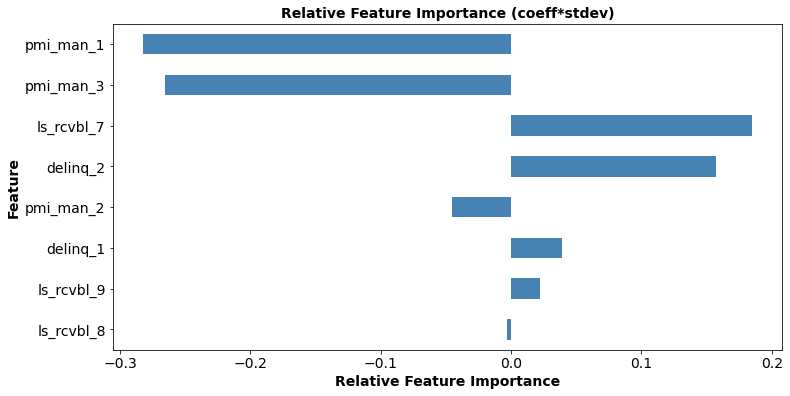

In [9]:
#horizontal bar plot
fig02, axes02 = plt.subplots(nrows=1,ncols=1,figsize=(12,6))

df_LR_FeaImp.sort_values(by='imp_rel_rk',ascending=False).plot.barh(ax=axes02,x='feat_label',y='imp_rel',rot=0,color='steelblue')

axes02.set_title('Relative Feature Importance (coeff*stdev)', fontsize = 14.0, fontweight='bold')
axes02.set_xlabel('Relative Feature Importance', fontsize = 14.0, fontweight='bold')
axes02.tick_params(axis='x', labelsize=14)
axes02.set_ylabel('Feature', fontsize = 14.0, fontweight='bold') 
axes02.tick_params(axis='y', labelsize=14)
axes02.get_legend().remove()

### <b><font color='blue'> Interpretation: Linear Regression Model - Feature Importance </font></b>
In examining the measures of feature importance, the results are similar to what has been indicated in both the Exploratory Data Analysis and in the time series model fitting.  There are dependencies at short lags, near lag 2, and longer lags near lag 7 or 8 or so.  The short lags include both autocorrelation in lease deliquency rate and a correlation of lease delinquency rate with feature variables while longer lags involve a correlation of lease delinquency rate with feature variables. <br>

Interestingly, the four most important features dominate the overall feature impact, with the impact declining substantially starting at the fifth feature. This result is consistent with the time series results in that the best models contain about 4 parameters and the improvement in fit from adding additional parameters has declining value.  To be clear, relative feature importance as measured above in the regression model is not that same as improvement in fit in cross-validation, but they are related in that a parameter with a small coefficient will have less scope for explaining variance in the target variable (e.g., a zero-valued coefficient explains no additional variance as values in the predictor vary).

## 3 All Models: Assess Fit & Residuals, Intrepret Results, Next Steps
Given the results above, I have now fit four models to the data, three ARIMA time series models ('Baseline ARIMA', 'Null ARIMA Exog', 'Full ARIMA'; I have added ARIMA to the labels for Baseline and Full to help further distinguish these models now that I am also considering a non-ARIMA regression model in this section) and one regression model ('Regression'). Below for these four models, I compare the Absolute Percent Error (APE) on the training and test data, examine the partial autocorrelation of the residuals from the fitted models, and finally interpret the results.
### <b>3.1 Absolute Percent Error (APE) </b>
<b>Plot of APE by Model</b>

APE for the training data are indicated by blue boxplots.  APE for the test data are shown by orange circles for the four test data points and black diamonds for the mean of these four test points to give Mean Absolute Percent Error (MAPE) for each of the four models.

In [10]:
#combine to one dataframe
#subsets
colset03_011 = ['y_pred_cv','y_resid_cv','y_ape_cv','model']
colset03_012 = ['y_pred_reg','y_resid_reg','y_ape_reg','model']
colset03_021 = ['y_pred','y_resid','y_ape','model']
#train
is_train_base_idx03 = df_base_pred_best.index < df_full.loc[is_test_idx01,'delinq'].index.min()
is_train_exog_idx03 = df_exog_pred_best.index < df_full.loc[is_test_idx01,'delinq'].index.min()
is_train_full_idx03 = df_full_pred_best.index < df_full.loc[is_test_idx01,'delinq'].index.min()
is_train_reg_idx03 = df_reg_pred.index < df_full.loc[is_test_idx01,'delinq'].index.min()
#test
is_test_base_idx03 = df_base_pred_best.index >= df_full.loc[is_test_idx01,'delinq'].index.min()
is_test_exog_idx03 = df_exog_pred_best.index >= df_full.loc[is_test_idx01,'delinq'].index.min()
is_test_full_idx03 = df_full_pred_best.index >= df_full.loc[is_test_idx01,'delinq'].index.min()
is_test_reg_idx03 = df_reg_pred.index >= df_full.loc[is_test_idx01,'delinq'].index.min()
#label models by train, test
df_base_pred_best.loc[is_train_base_idx03,'model'] = '11 Baseline Trn'
df_base_pred_best.loc[is_test_base_idx03,'model'] = '12 Baseline Tst'
df_exog_pred_best.loc[is_train_exog_idx03,'model'] = '21 Null ARIMA Exog Trn'
df_exog_pred_best.loc[is_test_exog_idx03,'model'] = '22 Null ARIMA Exog Tst'
df_full_pred_best.loc[is_train_full_idx03,'model'] = '31 Full Trn'
df_full_pred_best.loc[is_test_full_idx03,'model'] = '32 Full Tst'
df_reg_pred.loc[is_train_reg_idx03,'model'] = '41 Regression Trn'
df_reg_pred.loc[is_test_reg_idx03,'model'] = '42 Regression Tst'
#standardize colulmns
df_base_pred = df_base_pred_best.loc[:,colset03_011]
df_base_pred.columns = colset03_021
df_exog_pred = df_exog_pred_best.loc[:,colset03_011]
df_exog_pred.columns = colset03_021
df_full_pred = df_full_pred_best.loc[:,colset03_011]
df_full_pred.columns = colset03_021
df_reg_pred_std = df_reg_pred.loc[:,colset03_012]
df_reg_pred_std.columns = colset03_021
#concatenate
df_pred_bymodel = pd.concat([df_base_pred,df_exog_pred,df_full_pred,df_reg_pred_std],axis=0)


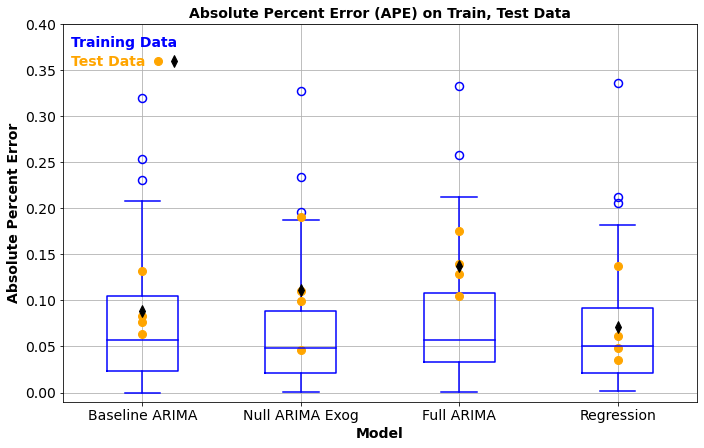

In [11]:
#plot APE on train, test over models
mod_trn_lst03 = ['11 Baseline Trn','21 Null ARIMA Exog Trn','31 Full Trn','41 Regression Trn']
mod_tst_lst03 = ['12 Baseline Tst','22 Null ARIMA Exog Tst','32 Full Tst','42 Regression Tst']
is_train_idx03 = df_pred_bymodel.loc[:,'model'].isin(mod_trn_lst03)
is_test_idx03 = df_pred_bymodel.loc[:,'model'].isin(mod_tst_lst03)
#MAPE by model, test data
df_apetest_mean_bymodel = df_pred_bymodel.loc[is_test_idx03,:].groupby('model').mean().loc[:,['y_ape']]
df_apetest_mean_bymodel.columns = ['mape']
df_apetest_mean_bymodel.index = ['Baseline ARIMA Test','Null ARIMA Exog Test','Full ARIMA Test','Regression Test']

fig03, axes03 = plt.subplots(nrows=1,ncols=1,figsize=(11,7))

#box plot training data
medianprp03 = dict(linestyle='-',linewidth=1.5,color='b')
boxprp03 = dict(linestyle='-',linewidth=1.5,color='b')
whiskerprp03 = dict(linestyle='-',linewidth=1.5,color='b')
capprp03 = dict(linestyle='-',linewidth=1.5,color='b')
flierprp03 = dict(marker='o',markersize=8,linestyle='none',markeredgecolor='b',markeredgewidth=1.5)
df_pred_bymodel.loc[is_train_idx03,:].boxplot(ax=axes03,column=['y_ape'],by='model',color='b',
   medianprops=medianprp03,boxprops=boxprp03,whiskerprops=whiskerprp03,capprops=capprp03,flierprops=flierprp03)

#add test data
xval031 = np.array([1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4])
plt.plot(xval031,df_pred_bymodel.loc[is_test_idx03,'y_ape'],color='orange',marker='o',markersize=8,linestyle='')
xval032 = np.array([1,2,3,4])
plt.plot(xval032,df_apetest_mean_bymodel.loc[:,'mape'],color='black',marker='d',markersize=8,linestyle='')

#format
fig03.suptitle('')
axes03.set_title('Absolute Percent Error (APE) on Train, Test Data',fontsize=14.0,fontweight='bold')
axes03.set_xlabel('Model',fontsize = 14.0,fontweight='bold')
plt.xticks([1, 2, 3, 4], ['Baseline ARIMA','Null ARIMA Exog','Full ARIMA','Regression'])
axes03.tick_params(axis='x',labelsize=14)
axes03.set_ylabel('Absolute Percent Error',fontsize = 14.0,fontweight='bold') 
axes03.tick_params(axis='y',labelsize=14)
axes03.set_ylim(-0.01,0.40)

#annotate
axes03.text(0.55,0.375,'Training Data',fontsize=14.0,color='blue',fontweight='bold')
axes03.text(0.55,0.355,'Test Data',fontsize=14.0,color='orange',fontweight='bold')
plt.plot(1.10,0.36,color='orange',marker='o',markersize=8,linestyle='')
plt.plot(1.20,0.36,color='black',marker='d',markersize=8,linestyle='')

<b>Mean Absolute Percent Error (MAPE) by Model on Test Data</b>

In [12]:
df_apetest_mean_bymodel

,mape
Baseline ARIMA Test,0.088476
Null ARIMA Exog Test,0.111554
Full ARIMA Test,0.137241
Regression Test,0.070766


### <b><font color='blue'> Interpretation: All Models - MAPE</font></b>
In terms of predicting the test data for the final four quarters of data {2020Q2,2020Q3,2020Q4,2021Q1}, the MAPE ranges from about 7% to about 14%, with the Regression and Baseline models performing the best and the Full model performaing the worst.  

Somewhat interestingly, the 2-parameter Baseline time series model, which is univariate, outperforms the more complex Full time series model that includes features as exogenous variables. Yet the Regression model, which makes use of features as predictor variables, outperforms all of the time series models, which suggests that the features have some predictive value.  It's important to note that the Regression model had the benefit of having the results of the time series analyses available to inform its feature selection because this analysis has not explored the full feature space because of its high dimensionality. 

### <b>3.2 Residual Partial Autocorrelation</b>
Combine predictions and metrics for the four models into a dataframe.

In [13]:
#data for partial autocorrelation
df_all_pred_resid = df_base_pred_best.loc[:,'y_resid_cv'].copy()
df_all_pred_resid.rename('y_base_resid_cv',inplace=True)
df_all_pred_resid = pd.concat([df_all_pred_resid, df_exog_pred_best.loc[:,'y_resid_cv']], axis=1, join='inner')
df_all_pred_resid.rename(columns={'y_resid_cv': 'y_exog_resid_cv'},inplace=True)
df_all_pred_resid = pd.concat([df_all_pred_resid, df_full_pred_best.loc[:,'y_resid_cv']], axis=1, join='inner')
df_all_pred_resid.rename(columns={'y_resid_cv': 'y_full_resid_cv'},inplace=True)
df_all_pred_resid = pd.concat([df_all_pred_resid, df_reg_pred.loc[:,'y_resid_reg']], axis=1, join='inner')
df_all_pred_resid.rename(columns={'y_resid_reg': 'y_reg_resid'},inplace=True)

Plot the partial autocorrelation of the residuals from the predictions of the four models.

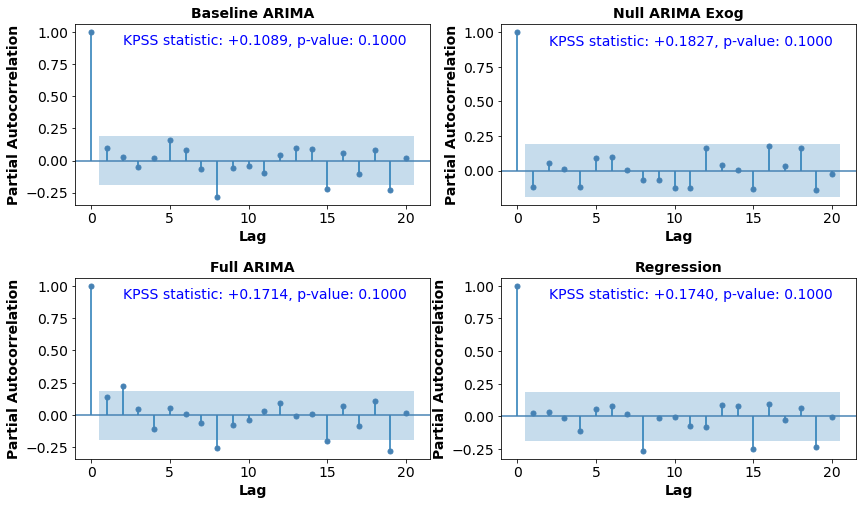

In [14]:
#calculate, plot partial autocorrelation
modelset04 = ['Baseline ARIMA','Null ARIMA Exog','Full ARIMA','Regression']
colset04 = ['y_base_resid_cv','y_exog_resid_cv','y_full_resid_cv','y_reg_resid']
kpss_raw = []

fig04, axes04 = plt.subplots(nrows=2,ncols=2,figsize=(14,8))
fig04.subplots_adjust(hspace=0.4)
ct04 = -1
for ax04 in axes04.flatten():
    ct04 = ct04 + 1
    
    #partial autocorrelation
    sm.graphics.tsa.plot_pacf(df_all_pred_resid.loc[:,colset04[ct04]],lags=20,ax=ax04,color='steelblue')
    ax04.set_title(modelset04[ct04], fontsize=14.0, fontweight='bold')
    ax04.set_xlabel('Lag', fontsize = 14.0, fontweight='bold')
    ax04.tick_params(axis='x', labelsize=14)
    ax04.set_ylabel('Partial Autocorrelation', fontsize=14.0, fontweight='bold') 
    ax04.tick_params(axis='y', labelsize=14)
    
    #kpss test
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        kpss_raw.append(sm.tsa.stattools.kpss(df_all_pred_resid.loc[:,colset04[ct04]],nlags='auto'))
    kpss_text04 = 'KPSS statistic: '+'{:+.4f}'.format(kpss_raw[ct04][0])
    kpss_text04 = kpss_text04 + ', p-value: '+'{:.4f}'.format(kpss_raw[ct04][1])
    
    #annotate
    ax04.text(2, 0.9, kpss_text04, fontsize=14.0, color='blue')

### <b><font color='blue'> Interpretation: All Models - Partial Autocorrelation</font></b>
Autocorrelation in lease delinquency rate for lags 1, 2, and 8 was observed in the Exploratory Data Analysis. After fitting the four models, autocorrelation at lags 1 and 2 was mostly removed and the autocorrelation at lag 8 was reduced, suggesting that the models are accounting for this structure in the data.  Some autocorrelation at lag 8 remains in the residuals and this would need to be further assessed to determine if this remaining autocorrelation is signal or simply noise in the data.

### <b>3.3 Interpret Results</b>
Modeling Results
<ol type="1">
   <li>The results from the Exploratory Data Analysis and the model fitting of both time series and regression models make clear that there is structure in these time series that correlates with time trends in lease delinquency rate. There is autocorrelation structure at short lags near lags 1 and 2 as well as longer lags near lag 8.  Further, the feature variables are correlated with lease delinquency rate over these same sets of lags. These are the most important modeling results because they form a foundation for what features can be examined to explain and predict lease delinquency rate.</li>
   <li>A second main result is the observed difference among the four models in performance on predicting the test data. On the one hand, adding features as exogenous variables in time series models increases MAPE relative to the univariate time series model without features.  Yet on the other hand, a simple linear regression model with 8 variables (6 of which are non-target features, the other two are lags in lease delinquency rate), is the best predictor of the test data, indicating that the features have predictive value.  One explanation for this difference in prediction error among models is that the regression model does not explicitly model autocorrelation (in fact, regression ignores autocorrelation [HA 2021] unless it is included as a predictor in the form of lag variables), and hence the regression model has a more flexible model structure in this regard. Another explanation is that the regression model better accounts for impacts for the different features by including more features, including more subtle dependencies among features.</li>
</ol>

Business Use Cases
<ol type="1">
  <li>The target variable, lease delinquency rate, and the features are in time series with quarterly observations.  Quarterly observations are somewhat course-grained for predicting business trends that might inform credit decision and lease servicing policies at banks which could then also subsequently reduce delinquency rate and then improve bank profitability.  Hence, forecasts of delinquency rate over the next one to few quarters are likely to be the most valuable to bank managers, with a one-quarter-ahead forecast likely to be the most practical and impactful.<br>
    
The regression model predicts the lease delinquency for the first quarter in the test data after the training series, quarter '2020Q2', with about 6% error (recall, the definition of MAPE is a relative error).  For quarter '2020Q2', the actual delinquency rate is 1.53% and the regression predicted delinquency rate is 1.44% (see results in the next cell). From a more qualitative perspective, all 4 models predict an increase in delinquency rate from '2020Q1' to '2020Q2' relative to '2019Q4', which can be useful to bank managers to simply help understand the directionality of current market trends and tendencies.</li>

   <li>Beyond prediction, an important business use case is understanding the relationships among different economic variables and specifically how other economical variables (features) may be predictive of lease delinquency rate.  Several of the economic features showed correlations with lease delinquency rate at one or more lags. 
    
Some relationships to highlight based on the modeling results include:
* Lease Delinquency Rate shows positive autocorrelation at lags 1 and 2. This could be related to the amount of time a lease remains in delinquency status before being charged off.
* The ISM Purchasing Managers Index (PMI) at lag 1 shows negative correlation with delinquency rate.  This indicates that changes in lease delinquency rate tend to move in the opposite direction of changes in PMI in the prior quarter. Increases in PMI indicate positive economic activity which is consistent with a decline in lease delinquency rate as leasees are more likely to make timely payments when the economic environment is positive.   
* Lease Receivable Balance at lags 7 and 8 shows positive correlations with delinquency rate.  This indicates that increases in lending (in the form of additional lease activity) is related to higher delinquency rates after about 2 years (8 quarters).  Excessive increases in leasing, especially in advance of economic downturns like recessions, could indicate excessive extension of credit which eventually leads to higher payment defaults and higher delinquency rates.</li>
</ol>

Lease delinquency rate in quarter '2020Q2': actual, predicted, mape

In [15]:
qtr_stg01 = '2020Q2'
print('Actual',qtr_stg01)
print(df_full.loc[qtr_stg01,'delinq'],'\n')

print(modelset04,'\n')

print('Predicted',qtr_stg01)
print(df_base_pred_best.loc[qtr_stg01,'y_pred_bic'].round(3),
df_exog_pred_best.loc[qtr_stg01,'y_pred_cv'].round(3),
df_full_pred_best.loc[qtr_stg01,'y_pred_cv'].round(3),
df_reg_pred.loc[qtr_stg01,'y_pred_reg'].round(3),'\n')

print('APE',qtr_stg01)
print(df_base_pred_best.loc[qtr_stg01,'y_ape_bic'].round(3),
df_exog_pred_best.loc[qtr_stg01,'y_ape_cv'].round(3),
df_full_pred_best.loc[qtr_stg01,'y_ape_cv'].round(3),
df_reg_pred.loc[qtr_stg01,'y_ape_reg'].round(3))

Actual 2020Q2
1.53 

['Baseline ARIMA', 'Null ARIMA Exog', 'Full ARIMA', 'Regression'] 

Predicted 2020Q2
1.309 1.378 1.369 1.436 

APE 2020Q2
0.145 0.1 0.105 0.062


### <b>3.4 Next Steps</b>
The results from these analyses suggest several possible next steps that could be implemented to extend the current methods.
<ol type="1">
   <li>Feature Engineering
   
   The model fitting indicates the importance of autocorrelation and lagged feature variables, but only the most basic linear models have been considered.  More detailed feature engineering could be informative and result in more predictive models.  Additional feature engineering could include (a) parametric functions to weight lagged variables using fewer parameters (versus having a coefficient parameter for each lagged variable), (b) nonlinear functions of lagged variables (e.g., declining impact as feature values increase), and (c) interactions among features (which are not considered in the simple linear models analyzed here).</li>
   <li>Alternative Modeling Techniques
   
   Another route for extensions is to evaluate alternative modeling techniques. A multivariate time series approach, VARMAX, is one alternative. Another possible approach is to use Decision Trees and their extenstions such as Random Forests and Gradient Boosting.</li>
   <li>Additional Data
   
   A final route for extending the model fitting is to enrich the data. Banks carefully measure deliquency rates and this more granular and detailed data would offer another possibility for extending the analyses with more frequent data (e.g., monthly) and additional attributes to use as features (e.g., various leasee attributes).</li>
</ol>
